In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
%load_ext autoreload
autoreload=2
%matplotlib inline

In [197]:
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

### EuroSAT github folder https://github.com/phelber/EuroSAT
[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.

In [ ]:
if not os.path.exists('Data'):
    os.makedirs('Data')

In [11]:
! wget -P Data/ http://madm.dfki.de/files/sentinel/EuroSAT.zip
! unzip Data/EuroSAT.zip -d Data
! rm Data/EuroSAT.zip
# You can simply download the EuroSAT data and manually unzip it in Data folder

--2021-03-23 19:58:37--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Résolution de madm.dfki.de (madm.dfki.de)… 131.246.195.183
Connexion à madm.dfki.de (madm.dfki.de)|131.246.195.183|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 94280567 (90M) [application/zip]
Sauvegarde en : « Data/EuroSAT.zip »

EuroSAT.zip         100%[===================>]  89,91M  32,6MB/s    ds 2,8s    

2021-03-23 19:58:40 (32,6 MB/s) — « Data/EuroSAT.zip » sauvegardé [94280567/94280567]

Archive:  Data/EuroSAT.zip
   creating: Data/2750/
   creating: Data/2750/River/
  inflating: Data/2750/River/River_479.jpg  
  inflating: Data/2750/River/River_2178.jpg  
  inflating: Data/2750/River/River_65.jpg  
  inflating: Data/2750/River/River_1643.jpg  
  inflating: Data/2750/River/River_191.jpg  
  inflating: Data/2750/River/River_636.jpg  
  inflating: Data/2750/River/River_2490.jpg  
  inflating: Data/2750/River/River_2337.jpg  
  inflating: Data/2750/River/River_982.jpg  
  in

In [16]:
# Show examples from the dataset
data_dir='Data/2750/'
lulc = os.listdir(data_dir)

In [58]:
examples=[]
for lc in lulc:
    images = os.listdir(os.path.join(data_dir,lc))
    images = [os.path.join(data_dir,lc,image) for image in images]
    samples = random.sample(images,5)
    examples.extend(samples)

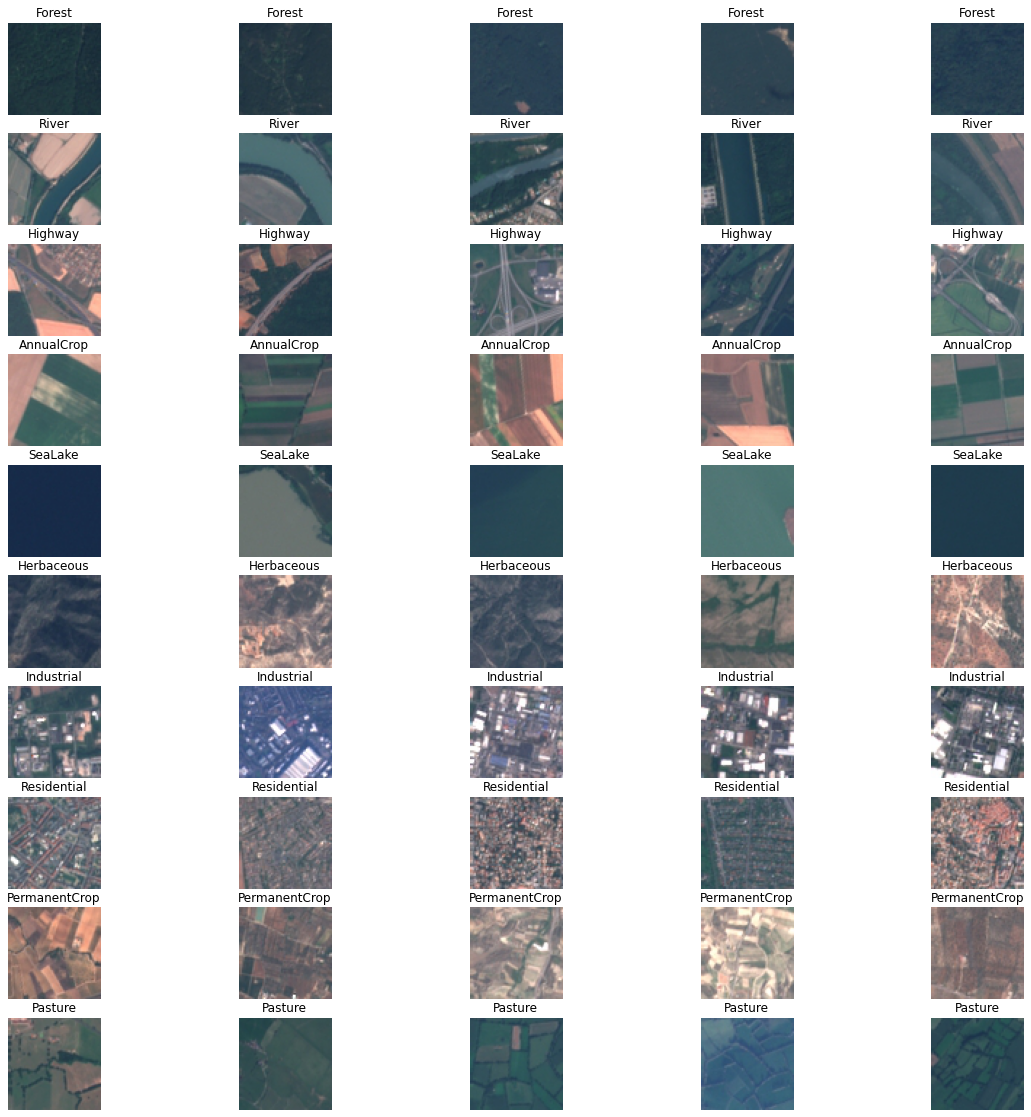

In [59]:
plt.figure(figsize=(20,20))
for i, im in enumerate(examples):
    plt.subplot(10,5,i+1)
    plt.imshow(np.array(Image.open(im)))
    plt.title(im.split('/')[2].replace('Vegetation',''))
    plt.axis('off')

In [142]:
# Load the data 
labels_dict ={'Forest': 0,'River': 1,'Highway': 2,'AnnualCrop': 3,'SeaLake': 4,'HerbaceousVegetation': 5,'Industrial': 6,'Residential': 7,'PermanentCrop': 8,'Pasture': 9}
X = []
y = []
for lc in lulc:
    images = os.listdir(os.path.join(data_dir,lc))
    images = [os.path.join(data_dir,lc,image) for image in images]
    for im in images:
        label = im.split('/')[2]
        label = labels_dict[label]
        if im.endswith('.jpg'):
            X.append(np.array(Image.open(im)))
            y.append(label)

In [143]:
# Split data into train and test 
# Since it's a multiclass classification the split is stratified (aka try to get a good representation of each class)
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [144]:
X_train = np.array(X_train)/255.
X_test = np.array(X_test)/255.
y_test = np.array(y_test)
y_train = np.array(y_train)

In [145]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [146]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [147]:
from keras.utils.np_utils import to_categorical

In [148]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [149]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, epochs=10, 
                    validation_data=(X_test, y_test_cat))

Train on 18900 samples, validate on 8100 samples
Epoch 1/10
18900/18900 [==============================] - 297s 16ms/sample - loss: 1.4575 - accuracy: 0.4315 - val_loss: 1.1161 - val_accuracy: 0.5753
Epoch 2/10
18900/18900 [==============================] - 296s 16ms/sample - loss: 0.9595 - accuracy: 0.6479 - val_loss: 0.7732 - val_accuracy: 0.7186
Epoch 3/10
18900/18900 [==============================] - 300s 16ms/sample - loss: 0.7955 - accuracy: 0.7133 - val_loss: 0.6955 - val_accuracy: 0.7501
Epoch 4/10
18900/18900 [==============================] - 305s 16ms/sample - loss: 0.6709 - accuracy: 0.7558 - val_loss: 0.6713 - val_accuracy: 0.7675
Epoch 5/10
18900/18900 [==============================] - 282s 15ms/sample - loss: 0.5901 - accuracy: 0.7853 - val_loss: 0.6191 - val_accuracy: 0.7753
Epoch 6/10
18900/18900 [==============================] - 274s 14ms/sample - loss: 0.5310 - accuracy: 0.8060 - val_loss: 0.6055 - val_accuracy: 0.7858
Epoch 7/10
18900/18900 [=====================

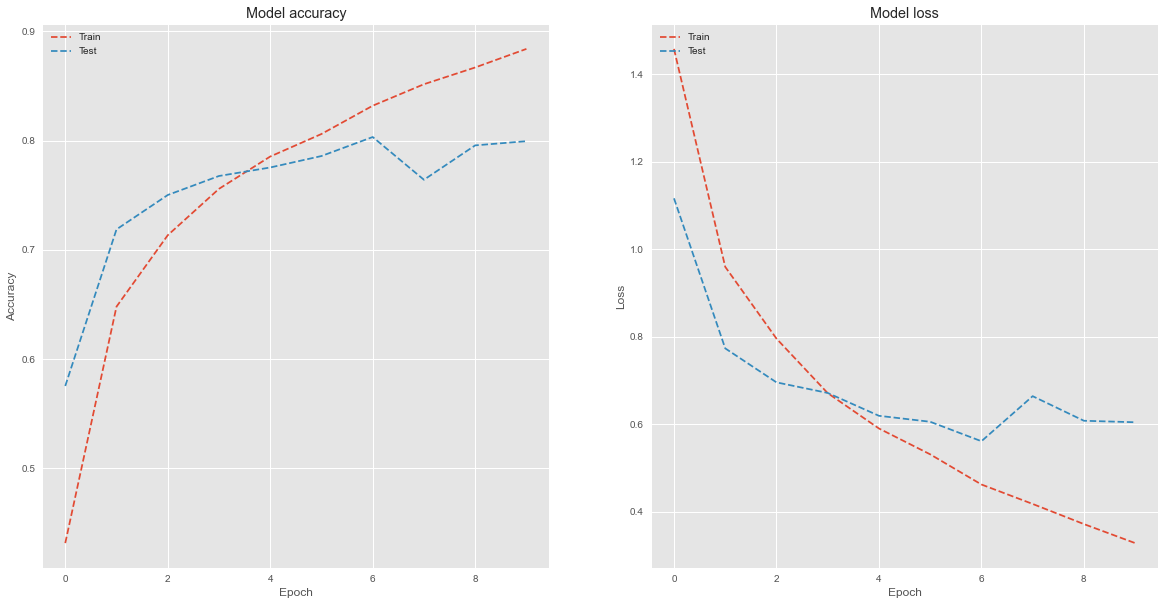

In [200]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'--')
plt.plot(history.history['val_accuracy'],'--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],'--')
plt.plot(history.history['val_loss'],'--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [150]:
model_json = model.to_json()
with open("model_EuroSAT.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [152]:
y_pred = model.predict(X_test)

In [166]:
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))

In [167]:
matrix

array([[809,  11,   2,   0,  40,  28,   0,   0,   0,  10],
       [  8, 494, 172,  29,   3,  11,   2,   0,   7,  24],
       [  0,  56, 585,  15,   0,  22,  16,  16,  37,   3],
       [  9,  23,  48, 716,   8,  23,   0,   1,  36,  36],
       [  3,   9,   2,  10, 866,   6,   0,   0,   0,   4],
       [  1,  16,  49,   7,   2, 708,  10,  28,  71,   8],
       [  0,   5,  94,   0,   0,   4, 607,  38,   2,   0],
       [  0,   1,  38,   0,   0,  16,  17, 826,   2,   0],
       [  0,  16, 115,  57,   0, 125,  10,   7, 404,  16],
       [ 31,  30,  18,   7,   2,  32,   0,   0,  20, 460]])

In [195]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization


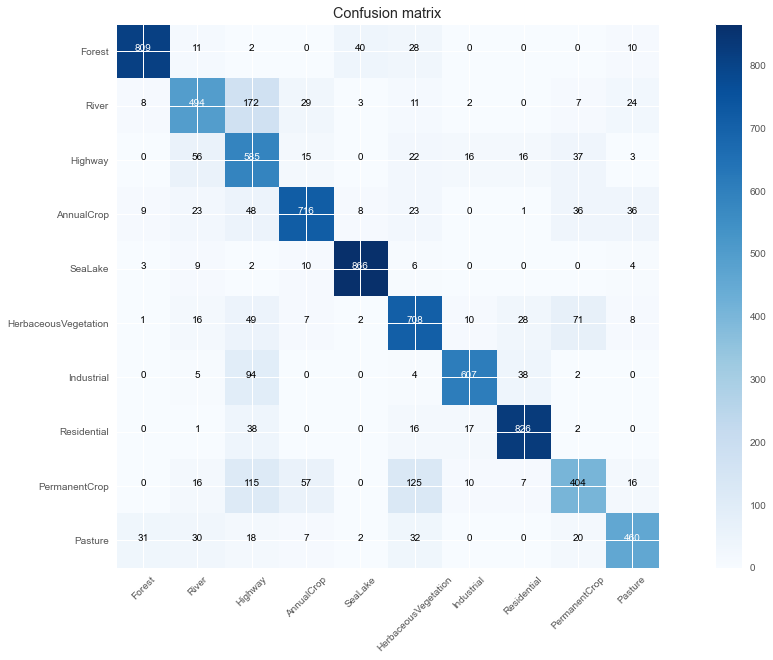

In [196]:
plt.figure(figsize=(20,10))
plot_confusion_matrix(matrix,classes=labels_dict.keys())